In [1]:
from datasets import load_dataset
import pandas as pd
import logging
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
import os
from langchain_cohere import ChatCohere

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display, HTML
import json
import csv

d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('scienceqa_clean.csv')

In [3]:
df.head()

,Unnamed: 0,question_id,question,choices,answer,hint,task,grade,subject,topic,...,split,choice_1,choice_2,choice_3,choice_4,original_answer,answer_humanity,has_solution,has_lecture,has_hint
0,10,1,Complete the sentence.\nSewing an apron is a ().,"['chemical change', 'physical change']",1,NaN,closed choice,grade4,natural science,chemistry,...,train,chemical change,physical change,NaN,NaN,physical change,2,1,1,0
1,18,2,"Based on this information, what is Daffodil's ...","['not having horns', 'having horns']",0,"In a group of cows, some individuals have horn...",closed choice,grade7,natural science,biology,...,val,not having horns,having horns,NaN,NaN,not having horns,1,1,1,1
2,20,3,What do these two changes have in common?\ntea...,"['Both are only physical changes.', 'Both are ...",0,NaN,closed choice,grade4,natural science,chemistry,...,train,Both are only physical changes.,Both are chemical changes.,Both are caused by cooling.,Both are caused by heating.,Both are only physical changes.,1,1,1,0
3,26,4,How long does it take to bake lasagna in the o...,"['33 minutes', '33 hours']",0,Select the better estimate.,closed choice,grade2,natural science,units-and-measurement,...,test,33 minutes,33 hours,NaN,NaN,33 minutes,1,1,1,1
4,29,5,What do these two changes have in common?\ncom...,"['Both are caused by cooling.', 'Both are only...",3,NaN,closed choice,grade4,natural science,chemistry,...,test,Both are caused by cooling.,Both are only physical changes.,Both are caused by heating.,Both are chemical changes.,Both are chemical changes.,4,1,1,0


In [18]:
# فیلتر کردن سطرهایی که در هر سه ستون 'hint'، 'solution' و 'lecture' مقدار دارند
test_df = df[df['hint'].notna() & df['solution'].notna() & df['lecture'].notna() &
                      (df['hint'].str.strip() != '') & (df['solution'].str.strip() != '') & 
                      (df['lecture'].str.strip() != '')]




In [21]:
test_df['topic'].value_counts()

topic
biology                  882
units-and-measurement    845
physics                  559
economics                217
chemistry                115
earth-science            101
world-history              1
Name: count, dtype: int64

In [22]:
test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.head()

C:\Users\scorp\AppData\Local\Temp\ipykernel_1276\1189359044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['Unnamed: 0'], inplace=True)


,question_id,question,choices,answer,hint,task,grade,subject,topic,category,...,split,choice_1,choice_2,choice_3,choice_4,original_answer,answer_humanity,has_solution,has_lecture,has_hint
1,2,"Based on this information, what is Daffodil's ...","['not having horns', 'having horns']",0,"In a group of cows, some individuals have horn...",closed choice,grade7,natural science,biology,Genes to traits,...,val,not having horns,having horns,NaN,NaN,not having horns,1,1,1,1
3,4,How long does it take to bake lasagna in the o...,"['33 minutes', '33 hours']",0,Select the better estimate.,closed choice,grade2,natural science,units-and-measurement,Units and measurement,...,test,33 minutes,33 hours,NaN,NaN,33 minutes,1,1,1,1
5,6,What is the volume of a large soup pot?,"['7 liters', '7 milliliters']",0,Select the better estimate.,closed choice,grade5,natural science,units-and-measurement,Units and measurement,...,train,7 liters,7 milliliters,NaN,NaN,7 liters,1,1,1,1
7,8,Is the following trait inherited or acquired?\...,"['inherited', 'acquired']",1,Hint: Playing soccer takes practice.,closed choice,grade3,natural science,biology,Heredity,...,train,inherited,acquired,NaN,NaN,acquired,2,1,1,1
8,9,"Based on this information, what is Holly's phe...","['straight whiskers', 'curved whiskers']",0,"In a group of Syrian hamsters, some individual...",closed choice,grade8,natural science,biology,Genes to traits,...,train,straight whiskers,curved whiskers,NaN,NaN,straight whiskers,1,1,1,1


In [23]:
test_df.topic.value_counts()

topic
biology                  882
units-and-measurement    845
physics                  559
economics                217
chemistry                115
earth-science            101
world-history              1
Name: count, dtype: int64

In [24]:
test_df.columns

Index(['question_id', 'question', 'choices', 'answer', 'hint', 'task', 'grade',
       'subject', 'topic', 'category', 'skill', 'lecture', 'solution', 'split',
       'choice_1', 'choice_2', 'choice_3', 'choice_4', 'original_answer',
       'answer_humanity', 'has_solution', 'has_lecture', 'has_hint'],
      dtype='object')

In [26]:
# Sample 5 entries from each topic category
sampled_df = test_df.groupby('topic').apply(lambda x: x.sample(n=10, replace=True) if len(x) >= 10 else x)

sampled_df

C:\Users\scorp\AppData\Local\Temp\ipykernel_1276\3424675964.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = test_df.groupby('topic').apply(lambda x: x.sample(n=10, replace=True) if len(x) >= 10 else x)


question_id  \
topic                                     
biology               5538         5539   
                      5525         5526   
                      1843         1844   
                      4122         4123   
                      5499         5500   
...                                 ...   
units-and-measurement 2611         2612   
                      4491         4492   
                      5116         5117   
                      4279         4280   
world-history         3618         3619   

                                                                     question  \
topic                                                                           
biology               5538  Is the following trait inherited or acquired?\...   
                      5525  Based on this information, what is Josiah's ph...   
                      1843  Based on this information, what is Cotton's ph...   
                      4122  Based on this information, what is this plant'...   
                      5499  Based on this information, what is this pea pl...   
...                                                                       ...   
units-and-measurement 2611                        How long is a soccer field?   
                      4491                      How long is a sunflower seed?   
                      5116                      How long is the Panama Canal?   
                      4279                              How long is a guitar?   
world-history         3618  Complete the sentence.\nIn this case, the prog...   

                                                                      choices  \
topic                                                                           
biology               5538                          ['inherited', 'acquired']   
                      5525           ['Aa', 'not having sickle-cell disease']   
                      1843                       ['wavy fur', 'straight fur']   
                      4122                      ['yellow peas', 'green peas']   
                      5499                               ['Dd', 'green pods']   
...                                                                       ...   
units-and-measurement 2611            ['375 feet', '375 inches', '375 yards']   
                      4491  ['15 millimeters', '15 meters', '15 centimeter...   
                      5116  ['80 kilometers', '80 millimeters', '80 centim...   
                      4279   ['33 inches', '33 feet', '33 miles', '33 yards']   
world-history         3618  ['secondary . . . was made in the 2000s by his...   

                            answer  \
topic                                
biology               5538       0   
                      5525       1   
                      1843       1   
                      4122       0   
                      5499       1   
...                            ...   
units-and-measurement 2611       0   
                      4491       0   
                      5116       0   
                      4279       0   
world-history         3618       1   

                                                                         hint  \
topic                                                                           
biology               5538  Hint: Erica was born with five toes on each foot.   
                      5525  This passage describes the sickle-cell disease...   
                      1843  In a group of Syrian hamsters, some individual...   
                      4122  In a group of pea plants, some individuals hav...   
                      5499  In a group of pea plants, some individuals hav...   
...                                                                       ...   
units-and-measurement 2611                          Select the best estimate.   
                      4491                          Select the best estimate.   
                      5116                          Sel

In [27]:
sampled_df.topic.value_counts()

topic
biology                  10
chemistry                10
earth-science            10
economics                10
physics                  10
units-and-measurement    10
world-history             1
Name: count, dtype: int64

In [28]:
sampled_df.to_csv('scqa_for_inference_en.csv')
sampled_df.to_csv('scqa_for_inference_fa.csv')

In [12]:
import cohere

# تنظیم API Key
cohere_client = cohere.Client("k4nv2XHVUMI9IDp3R4TV5jyzax5DufqG1nZDh5up")

# درخواست به مدل برای دریافت خروجی با logprobs
response = cohere_client.generate(
    model='command-r-plus',  # انتخاب مدل دلخواه مثل xlarge یا base
    prompt="What are the key factors of economic growth?",
    max_tokens=50,
    return_likelihoods='GENERATION',
)

response


Generation(id='165214fa-a060-4f09-a0db-c164679071b2', prompt='What are the key factors of economic growth?', generations=[SingleGeneration(id='ff9c7961-5828-4f2a-8a9b-94245c4bd768', text='Economic growth refers to an increase in the capacity of an economy to produce goods and services over time. It is typically measured by indicators such as gross domestic product (GDP) or gross national income (GNI). There are several key factors that contribute to', index=None, likelihood=-0.117722474, token_likelihoods=[SingleGenerationTokenLikelihoodsItem(token='Economic', likelihood=-0.67395633), SingleGenerationTokenLikelihoodsItem(token=' growth', likelihood=-1.4066795e-05), SingleGenerationTokenLikelihoodsItem(token=' refers', likelihood=-0.42887524), SingleGenerationTokenLikelihoodsItem(token=' to', likelihood=-9.536748e-07), SingleGenerationTokenLikelihoodsItem(token=' an', likelihood=-0.41459376), SingleGenerationTokenLikelihoodsItem(token=' increase', likelihood=-4.4107533e-06), SingleGener

In [ ]:
# ارسال درخواست به مدل برای دریافت خروجی با logprobs
response = cohere_client.generate(
    model='command-r-plus',  # انتخاب مدل دلخواه
    prompt="What are the key factors of economic growth?",
    max_tokens=50,
    logprobs=5,  # گرفتن 5 توکن بعدی همراه با احتمالاتشان
    return_prompt=True  # برگرداندن متن ورودی همراه با خروجی
)

# نمایش خروجی
generated_text = response['text']
tokens = response['tokens']
logprobs = response['logprobs']

# چاپ توکن‌ها و احتمالات
for idx, token in enumerate(tokens):
    print(f"Token: {token}")
    print(f"Log Probability: {logprobs['token_logprobs'][idx]}")
    print(f"Probability: {round(2.718 ** logprobs['token_logprobs'][idx], 4)}")
    print("-" * 40)

# تحلیل اینکه مدل بیشتر به کدام بخش توجه کرده
print(f"Generated Text: {generated_text}")


TypeError: generate() got an unexpected keyword argument 'logprobs'

In [ ]:
# ارسال درخواست به مدل با استفاده از temperature و top_p
response = cohere_client.generate(
    model='command-r-plus',  # انتخاب مدل دلخواه
    prompt="What are the key factors of economic growth?",
    max_tokens=50,
    temperature=0.7,  # مقدار temperature برای کنترل تصادفی بودن پاسخ‌ها
    top_p=0.9,  # مقدار top_p برای محدود کردن توزیع احتمالات
    return_prompt=True,  # برگرداندن متن ورودی همراه با خروجی
)

# نمایش خروجی
generated_text = response['text']
tokens = response['tokens']

print(f"Generated Text: {generated_text}")
print("Tokens: ", tokens)


TypeError: generate() got an unexpected keyword argument 'top_p'

In [1]:
import cohere

# تنظیم API Key
cohere_client = cohere.Client("k4nv2XHVUMI9IDp3R4TV5jyzax5DufqG1nZDh5up")

In [6]:
# ارسال درخواست به مدل برای دریافت خروجی به همراه likelihood
response = cohere_client.generate(
    model='command-r-plus',  # انتخاب مدل دلخواه
    prompt="What are the key factors of economic growth?",
    max_tokens=50,  # حداکثر تعداد توکن‌ها
    return_likelihoods='GENERATION',  # فقط likelihoodهای توکن‌های تولید شده
)

# نمایش خروجی و likelihood
generated_text = response.generations[0].text
likelihoods = response.generations[0].token_likelihoods  # احتمال هر توکن تولید شده

print(f"Generated Text: {generated_text}")
print("\nLikelihoods for generated tokens:")
for token, likelihood in zip(generated_text.split(), likelihoods):
    print(f"Token: {token}, Likelihood: {likelihood}")


Generated Text: Economic growth refers to the increase in the market value of the goods and services produced by an economy over time. It is typically measured by indicators such as gross domestic product (GDP) or gross national income (GNI). There are several key factors that

Likelihoods for generated tokens:
Token: Economic, Likelihood: token='Economic' likelihood=-0.67395633
Token: growth, Likelihood: token=' growth' likelihood=-1.1563368e-05
Token: refers, Likelihood: token=' refers' likelihood=-0.3416709
Token: to, Likelihood: token=' to' likelihood=-9.536748e-07
Token: the, Likelihood: token=' the' likelihood=-0.69347507
Token: increase, Likelihood: token=' increase' likelihood=-0.011373823
Token: in, Likelihood: token=' in' likelihood=-9.536748e-07
Token: the, Likelihood: token=' the' likelihood=-6.461352e-05
Token: market, Likelihood: token=' market' likelihood=-0.01785538
Token: value, Likelihood: token=' value' likelihood=-1.4305125e-06
Token: of, Likelihood: token=' of' lik

In [8]:
import matplotlib.pyplot as plt

# استخراج توکن‌ها و احتمال‌ها
tokens = generated_text.split()

# استخراج likelihood ها از response (دقت کنید که احتمال‌ها به صورت log likelihood هستند)
likelihood_values = [item.token_likelihood for item in response.generations[0].token_likelihoods]

# بررسی اینکه طول لیست‌ها برابر است
assert len(tokens) == len(likelihood_values), "تعداد توکن‌ها و likelihood‌ها برابر نیستند!"

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.bar(tokens, likelihood_values)
plt.xticks(rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihoods of Generated Tokens")
plt.show()


AttributeError: 'SingleGenerationTokenLikelihoodsItem' object has no attribute 'token_likelihood'

In [9]:
# چاپ ساختار response.generations[0].token_likelihoods
for item in response.generations[0].token_likelihoods:
    print(item)


token='Economic' likelihood=-0.67395633
token=' growth' likelihood=-1.1563368e-05
token=' refers' likelihood=-0.3416709
token=' to' likelihood=-9.536748e-07
token=' the' likelihood=-0.69347507
token=' increase' likelihood=-0.011373823
token=' in' likelihood=-9.536748e-07
token=' the' likelihood=-6.461352e-05
token=' market' likelihood=-0.01785538
token=' value' likelihood=-1.4305125e-06
token=' of' likelihood=-2.7418175e-06
token=' the' likelihood=-0.009423048
token=' goods' likelihood=-1.4305125e-06
token=' and' likelihood=-1.1920936e-06
token=' services' likelihood=-1.1920936e-06
token=' produced' likelihood=-0.00019522426
token=' by' likelihood=-1.01328405e-05
token=' an' likelihood=-0.00024136834
token=' economy' likelihood=-9.536748e-07
token=' over' likelihood=-2.586875e-05
token=' time' likelihood=-0.002476956
token='.' likelihood=-0.0024999012
token=' It' likelihood=-0.19633366
token=' is' likelihood=-0.0017779769
token=' typically' likelihood=-0.3535984
token=' measured' likel

تعداد توکن‌ها: 51
تعداد likelihood‌ها: 48


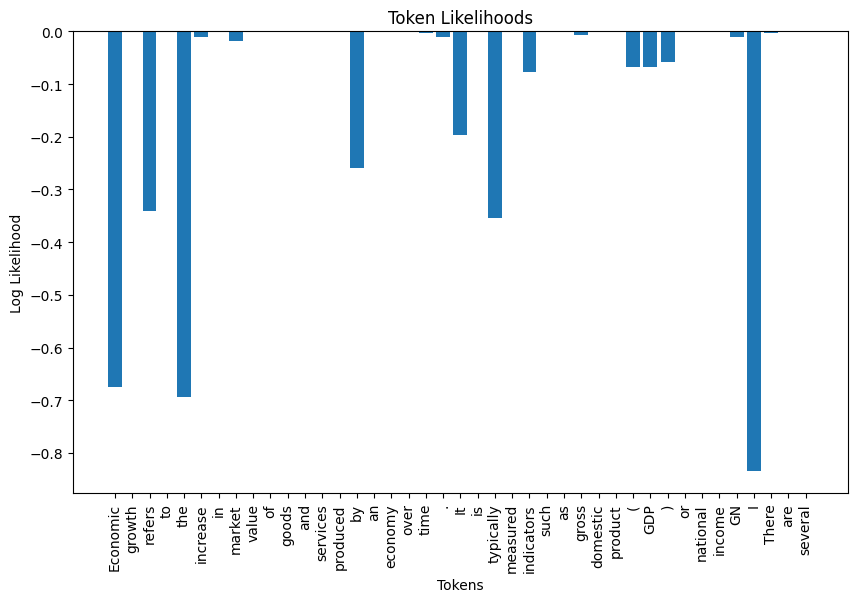

In [11]:
# بررسی طول هر دو لیست
print(f"تعداد توکن‌ها: {len(tokens)}")
print(f"تعداد likelihood‌ها: {len(likelihood_values)}")

# اگر طول‌ها برابر نیستند، یکی از لیست‌ها را کوتاه کنیم تا برابر شوند
min_length = min(len(tokens), len(likelihood_values))
tokens = tokens[:min_length]
likelihood_values = likelihood_values[:min_length]

# رسم نمودار دوباره با لیست‌های اصلاح‌شده
plt.figure(figsize=(10, 6))
plt.bar(tokens, likelihood_values)
plt.xticks(rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Log Likelihood")
plt.title("Token Likelihoods")
plt.show()


In [ ]:
# Function to predict the answer and save the full generation to a CSV file
def predict_answer_and_save(passage, question, options, correct_answer, llm, generation_file):
    logging.info(f"Starting prediction for passage: {passage[:50]}... and question: {question}")
    try:
        # Determine the number of options based on available choices
        choices = [options[i] for i in range(len(options)) if options[i] != ""]

        # Define the messages based on the new prompt format
        messages = [
            {
                "role": "system",
                "content": (
                    "You will receive a `QUESTION` with multiple `ANSWER CHOICES` and a supporting `CONTEXT`. "
                    "Your task is to determine the correct answer based on the information in the context and to explain "
                    "your reasoning step-by-step, referencing key details from the context.\n\n"
                    "Follow these instructions for your response:\n\n"
                    "Select only one answer choice based on your understanding of the context.\n"
                    "   - Format: <answer>[Your CHOICE here]</answer>\n\n"
                    "Provide a detailed, step-by-step explanation of how you arrived at the answer, focusing on the logical reasoning process. "
                    "Include references to relevant parts of the context to support each reasoning step. `The explanation must be in Persian.`\n"
                    "   - Format: <explanation>[Step-by-step reasoning and references to context here]</explanation>\n\n"
                    "Identify and quote the most relevant parts of the context that were essential in answering the question. "
                    "Only include the specific information that directly supports your chosen answer. `Ensure this is in Persian.`\n"
                    "   - Format: <highlight>[Key supporting context here]</highlight>\n\n"
                    "List the most important keywords from the context that are essential for understanding and answering the question. "
                    "`Provide keywords as a Python list, in Persian.`\n"
                    "   - Format: <keywords>[Relevant KEYWORDS here]</keywords>\n\n"
                    "---\n\n"
                    "`Guidelines for Self-Explanation`:\n"
                    "- Make sure your explanation is complete, covering all reasoning steps used to reach the answer.\n"
                    "- Ensure your reasoning is relevant and directly tied to the context, avoiding any unrelated details.\n"
                    "- Keep the explanation clear and logical, with each step following naturally from the previous one.\n"
                    "- Reflect the information in the context faithfully, without adding unsupported assumptions."
                )
            },
            {
                "role": "user",
                "content": (
                    f"CONTEXT:\n{passage}\n\n"
                    f"QUESTION:\n{question}\n\n"
                    f"ANSWER CHOICES:\n"
                    + "\n".join([f"{i+1}-{choices[i]}" for i in range(len(choices))])  # Dynamically add choices
                )
            }
        ]
        
        # Invoke the language model
        result = llm.invoke(messages)
        
        # Save the full generation to a CSV file
        with open(generation_file, "a", encoding="utf-8") as f:
            writer = csv.writer(f)
            # Write headers if the file is empty
            if f.tell() == 0:
                writer.writerow(["Passage", "Question", "Options", "Original Answer", "Predicted Answer", "Correct Answer"])

            writer.writerow([passage, question, choices, correct_answer, result.content.strip(), correct_answer])

        logging.info(f"Full generation saved for parsing: {result.content.strip()}")
        return result.content.strip()
    except Exception as e:
        logging.error(f"Error in predict_answer_and_save: {e}")
        return "error"


In [9]:
from datasets import load_dataset

ds = load_dataset("allenai/openbookqa", "main")

d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\scorp\.cache\huggingface\hub\datasets--allenai--openbookqa. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 500/500 [00:00<00:00, 83306.27 examples/s]


In [11]:
from datasets import load_dataset

ds = load_dataset("allenai/openbookqa", "additional")

Generating test split: 100%|██████████| 500/500 [00:00<?, ? examples/s]


In [ ]:
ds

In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question_stem', 'choices', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized'],
        num_rows: 4957
    })
    validation: Dataset({
        features: ['id', 'question_stem', 'choices', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'question_stem', 'choices', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized'],
        num_rows: 500
    })
})

In [13]:
import pandas as pd

# Assuming the DatasetDict is stored in a variable called dataset_dict
# Convert each split (train, validation, test) into a pandas DataFrame
train_df = pd.DataFrame(ds['train'])
validation_df = pd.DataFrame(ds['validation'])
test_df = pd.DataFrame(ds['test'])

# Optionally, combine them into one dataframe if needed
# Combined DataFrame
combined_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)


In [14]:
combined_df

,id,question_stem,choices,answerKey,fact1,humanScore,clarity,turkIdAnonymized
0,7-980,The sun is responsible for,"{'text': ['puppies learning new tricks', 'chil...",D,the sun is the source of energy for physical c...,1.0,2.0,b356d338b7
1,7-584,When standing miles away from Mount Rushmore,"{'text': ['the mountains seem very close', 'th...",D,"as distance to an object increases , that obje...",1.0,1.4,b356d338b7
2,7-870,When food is reduced in the stomach,"{'text': ['the mind needs time to digest', 'ta...",C,digestion is when stomach acid breaks down food,1.0,1.6,b356d338b7
3,7-321,Stars are,"{'text': ['warm lights that float', 'made out ...",C,a star is made of gases,1.0,1.6,b356d338b7
4,9-732,You can make a telescope with a,"{'text': ['straw', 'Glass', 'Candle', 'mailing...",D,Galileo Galilei made improvements to the teles...,0.8,1.0,cee82219a0
...,...,...,...,...,...,...,...,...
5952,9-284,A person is heating water in order to cook pas...,"{'text': ['scalds', 'cools', 'toasts', 'freeze...",A,if liquid is boiling then that liquid is hot,1.0,2.0,b356d338b7
5953,7-1186,Pasta may be cooked in water when,"{'text': ['the water is warm', 'the water is o...",C,boiling is when liquids are heated above their...,1.0,1.2,b356d338b7
5954,926,A decrease in diseases,"{'text': ['has no impact on a population', 'le...",C,decreasing something negative has a positive i...,1.0,2.0,a8ecf6eaeb
5955,7-519,"When soil is viewed in a scientific way, what ...","{'text': ['insects like big beetles', 'tiny li...",B,studying a soil sample means studying the micr...,0.8,0.8,b356d338b7


In [23]:
# فرض بر این است که داده‌ها در یک متغیر به نام dataset_dict ذخیره شده‌اند

# تبدیل هر بخش (train، validation، test) به pandas DataFrame و اضافه کردن ستون 'source'
train_df = pd.DataFrame(ds['train'])
train_df['source'] = 'train'

validation_df = pd.DataFrame(ds['validation'])
validation_df['source'] = 'validation'

test_df = pd.DataFrame(ds['test'])
test_df['source'] = 'test'

# استخراج گزینه‌ها (choices) و اختصاص دادن به ستون‌های جدید
train_df[['choice_A', 'choice_B', 'choice_C', 'choice_D']] = pd.json_normalize(train_df['choices']).apply(lambda x: pd.Series(x['text']), axis=1)
validation_df[['choice_A', 'choice_B', 'choice_C', 'choice_D']] = pd.json_normalize(validation_df['choices']).apply(lambda x: pd.Series(x['text']), axis=1)
test_df[['choice_A', 'choice_B', 'choice_C', 'choice_D']] = pd.json_normalize(test_df['choices']).apply(lambda x: pd.Series(x['text']), axis=1)

# نگه داشتن سایر ستون‌ها به همراه گزینه‌ها و ستون 'source'
train_df = train_df[['id', 'question_stem', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized', 'source']]
validation_df = validation_df[['id', 'question_stem', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized', 'source']]
test_df = test_df[['id', 'question_stem', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'answerKey', 'fact1', 'humanScore', 'clarity', 'turkIdAnonymized', 'source']]

# ترکیب همه دیتافریم‌ها به یک دیتافریم واحد
combined_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)

In [24]:
combined_df

,id,question_stem,choice_A,choice_B,choice_C,choice_D,answerKey,fact1,humanScore,clarity,turkIdAnonymized,source
0,7-980,The sun is responsible for,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting",D,the sun is the source of energy for physical c...,1.0,2.0,b356d338b7,train
1,7-584,When standing miles away from Mount Rushmore,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,D,"as distance to an object increases , that obje...",1.0,1.4,b356d338b7,train
2,7-870,When food is reduced in the stomach,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works,C,digestion is when stomach acid breaks down food,1.0,1.6,b356d338b7,train
3,7-321,Stars are,warm lights that float,made out of nitrate,great balls of gas burning billions of miles away,lights in the sky,C,a star is made of gases,1.0,1.6,b356d338b7,train
4,9-732,You can make a telescope with a,straw,Glass,Candle,mailing tube,D,Galileo Galilei made improvements to the teles...,0.8,1.0,cee82219a0,train
...,...,...,...,...,...,...,...,...,...,...,...,...
5952,9-284,A person is heating water in order to cook pas...,scalds,cools,toasts,freezes,A,if liquid is boiling then that liquid is hot,1.0,2.0,b356d338b7,test
5953,7-1186,Pasta may be cooked in water when,the water is warm,the water is on the stove,water is bubbling from applied warmth,the pasta is very fresh,C,boiling is when liquids are heated above their...,1.0,1.2,b356d338b7,test
5954,926,A decrease in diseases,has no impact on a population,leads to more sick people,leads to less sick people,leads to an uptick in emergency room visits,C,decreasing something negative has a positive i...,1.0,2.0,a8ecf6eaeb,test
5955,7-519,"When soil is viewed in a scientific way, what ...",insects like big beetles,tiny lifeforms in dirt,small mammals living there,a lot of tiny pebbles,B,studying a soil sample means studying the micr...,0.8,0.8,b356d338b7,test


In [27]:
combined_df.to_csv('OpenBookQA_en.csv', index=False)

In [28]:
df = pd.read_csv('OpenBookQA_en.csv')
df

,id,question_stem,choice_A,choice_B,choice_C,choice_D,answerKey,fact1,humanScore,clarity,turkIdAnonymized,source
0,7-980,The sun is responsible for,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting",D,the sun is the source of energy for physical c...,1.0,2.0,b356d338b7,train
1,7-584,When standing miles away from Mount Rushmore,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,D,"as distance to an object increases , that obje...",1.0,1.4,b356d338b7,train
2,7-870,When food is reduced in the stomach,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works,C,digestion is when stomach acid breaks down food,1.0,1.6,b356d338b7,train
3,7-321,Stars are,warm lights that float,made out of nitrate,great balls of gas burning billions of miles away,lights in the sky,C,a star is made of gases,1.0,1.6,b356d338b7,train
4,9-732,You can make a telescope with a,straw,Glass,Candle,mailing tube,D,Galileo Galilei made improvements to the teles...,0.8,1.0,cee82219a0,train
...,...,...,...,...,...,...,...,...,...,...,...,...
5952,9-284,A person is heating water in order to cook pas...,scalds,cools,toasts,freezes,A,if liquid is boiling then that liquid is hot,1.0,2.0,b356d338b7,test
5953,7-1186,Pasta may be cooked in water when,the water is warm,the water is on the stove,water is bubbling from applied warmth,the pasta is very fresh,C,boiling is when liquids are heated above their...,1.0,1.2,b356d338b7,test
5954,926,A decrease in diseases,has no impact on a population,leads to more sick people,leads to less sick people,leads to an uptick in emergency room visits,C,decreasing something negative has a positive i...,1.0,2.0,a8ecf6eaeb,test
5955,7-519,"When soil is viewed in a scientific way, what ...",insects like big beetles,tiny lifeforms in dirt,small mammals living there,a lot of tiny pebbles,B,studying a soil sample means studying the micr...,0.8,0.8,b356d338b7,test


In [30]:
df['clarity'].value_counts()

clarity
2.00    2460
1.60    1032
1.80     949
1.40     500
1.20     414
1.00     184
0.80     139
0.60      48
0.40      45
1.67      38
1.33      36
0.00      17
1.50      16
1.17      16
0.20      10
1.83       9
1.75       9
0.83       7
0.50       6
0.67       6
1.25       3
0.33       3
1.71       3
1.29       2
0.71       1
1.86       1
0.86       1
1.14       1
1.37       1
Name: count, dtype: int64

In [31]:
sample_df = df.sample(n=100, random_state=42)

In [33]:
sample_df.to_csv('OpenBookQA_en_sample.csv')

In [2]:
import cohere

# Initialize Cohere client with your API key
co = cohere.ClientV2(
    api_key="k4nv2XHVUMI9IDp3R4TV5jyzax5DufqG1nZDh5up",
    log_warning_experimental_features=False,
    )

In [8]:
# Send a message with the instruction to generate JSON output based on the schema
res = co.generate(
    model="command-r-plus-08-2024",
    prompt=[
        {
            "role": "user",
            "content": "Generate a JSON with the fields 'answer', 'explanation', 'highlight', and 'keywords' where: "
                       "'answer' is an integer, 'explanation' and 'highlight' are texts, and 'keywords' is a list of strings."
        }
    ],
    response_format={
        "type": "json_object",
        "schema": {
            "type": "object",
            "properties": {
                "answer": {"type": "integer"},
                "explanation": {"type": "string"},
                "highlight": {"type": "string"},
                "keywords": {"type": "array", "items": {"type": "string"}}
            },
            "required": ["answer", "explanation", "highlight", "keywords"]
        },
    },
    return_likelihoods='GENERATION',
    
)

# Print the response
print(res.message.content[0].text)


TypeError: generate() got an unexpected keyword argument 'response_format'

In [9]:
co.generate(prompt="Hello")

Generation(id='2e1e0a28-459e-4080-9cbb-b4f5a202a6a1', prompt='Hello', generations=[SingleGeneration(id='cdd7d669-ac3c-419b-9a19-db6a8c159563', text=" Hi! What can I do for you today?  I can help in several ways, including:\n\n1. Answering questions: I can provide information and explanations on a wide range of topics, from science and history to everyday life and culture. If it's something complex, I'll do my best to provide a summary and overview so you can grasp the key points.\n\n2. Providing creative inspiration: I can assist you with brainstorming ideas, generating creative prompts, and suggesting innovative solutions to problems. Whether it's an artistic project, business venture, or personal challenge, I'll offer fresh perspectives to spark your imagination.\n\n3. Helping with language and writing: As a large language model, I can assist you in polishing your writing. I can perform grammar and spell checks, suggest rewrites for clarity or style improvements, and even help with l